# FaceNet PyTorch

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os
workers = 0 if os.name == 'nt' else 4

c:\Users\himek\miniconda3\envs\dltorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Repro [Github](https://github.com/timesler/facenet-pytorch)

In [3]:
# !git clone https://github.com/timesler/facenet-pytorch facenet_pytorch2
!git clone https://github.com/rkuo2000/facenet-pytorch facenet_pytorch

Cloning into 'facenet_pytorch'...


In [15]:
from facenet_pytorch import MTCNN, InceptionResnetV1

In [16]:
'''
giải thích các tham số
- image_size: size ảnh đầu ra
- margin=0: lề khuôn mặt được cắt, hiện tại là 0, tức là 0 có lề, chỉ cắt đúng khuôn mặt
Có thể thêm lề để mở rộng vùng khuôn mặt được trích xuất
- min_face_size=20: kích thước tối thiểu khuôn mặt
- threshold: ngưỡng xác xuất để xác định khuôn mặt ở mỗi tầng trong mạng mtcnn
- factor: hệ số giảm tỷ lệ ảnh liên tục. Chính là cái pyramid, chỉ giảm đến min_face_size
- post_process = True: mô hình sẽ thực hiện một số bước xử lý bổ sung sau khi
phát hiện khuôn mặt để cải thiện độ chính xác
'''

mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [17]:
net = InceptionResnetV1(pretrained='vggface2').eval().to(device)

## Prepare Datasets

In [18]:
'''
- collate_fn(x): nhận các mẫu trong một batch ảnh, và trả về phần tử đầu tiên của danh sách đó
- ImageFolder: quét qua thư mục test_images, tự động gán nhãn bằng tên các thư mục con trong đường dẫn
- dataset.idx_to_class: ánh xạ từ tên lớp tới chỉ số lớp, đảo ngược ánh xạ để có thể truy cập tên lớp từ chỉ số lớp
'''

def collate_fn(x):
    return x[0]

dataset = datasets.ImageFolder('facenet_pytorch/data/test_images')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [19]:
print(dataset.idx_to_class)

{0: 'angelina_jolie', 1: 'bradley_cooper', 2: 'kate_siegel', 3: 'minh', 4: 'paul_rudd', 5: 'shea_whigham'}


## perform NTCNN face detection

In [20]:
aligned = [] # lưu trữ khuôn mặt đã được căn chỉnh
names = []# lưu trữ các nhãn tương ứng
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)# trả về xác xuất của việc phát hiện khuôn mặt
    if x_aligned is not None:
        print('Face detected with probability: {:8f}'.format(prob))
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

Face detected with probability: 0.999983
Face detected with probability: 0.999934
Face detected with probability: 0.999734
Face detected with probability: 0.999998
Face detected with probability: 0.999876
Face detected with probability: 0.999992


In [21]:
print(len(aligned))
print(names)

6
['angelina_jolie', 'bradley_cooper', 'kate_siegel', 'minh', 'paul_rudd', 'shea_whigham']


## Evaluation

### calculate image embeddings

In [22]:
aligned = torch.stack(aligned).to(device) # ghép các tensor trong aligned thành 1 tensor duy nhất
embeddings = net(aligned).detach().cpu()# tạo các vector nhúng từ mô hình đã sử dung, ngắt kết nối các vector nhúng từ đồ thị tính toán

In [23]:
print(len(embeddings))

6


In [24]:
print(embeddings[0].shape)

torch.Size([512])


### print distance matrix for classes

In [25]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
# duyệt qua tất cả phần tử e2 với mỗi phàn tử e1, sau đó tính euclidean, chuyển giá trị két quả từ tensor thành float
print(pd.DataFrame(dists, columns=names, index=names))
# toàn bộ kq tính toán sẽ được lưu trong một danh sách lồng nhau

                angelina_jolie  bradley_cooper  kate_siegel      minh  \
angelina_jolie        0.000000        1.447503     0.887774  1.386029   
bradley_cooper        1.447503        0.000000     1.313683  1.596809   
kate_siegel           0.887774        1.313683     0.000000  1.350619   
minh                  1.386029        1.596809     1.350619  0.000000   
paul_rudd             1.434406        1.012063     1.389054  1.632373   
shea_whigham          1.399137        1.038769     1.379658  1.502303   

                paul_rudd  shea_whigham  
angelina_jolie   1.434406      1.399137  
bradley_cooper   1.012063      1.038769  
kate_siegel      1.389054      1.379658  
minh             1.632373      1.502303  
paul_rudd        0.000000      1.104298  
shea_whigham     1.104298      0.000000  


## Test : single face picture

In [26]:
from torchvision import transforms
import matplotlib.pyplot as plt

In [27]:
mtcnn = MTCNN(keep_all=False) # mô hình sẽ trả về khuôn mặt được phát hiện có độ tin cậy cao nhất

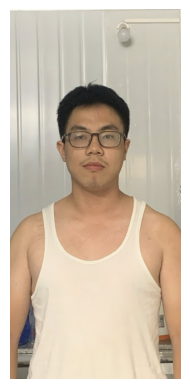

In [28]:
img = plt.imread("facenet_pytorch/data/test_images/minh/1.jpg")
plt.axis('off')
pic = plt.imshow(img)

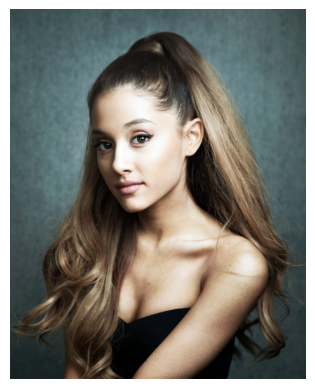

In [24]:
import urllib
from PIL import Image
img = Image.open(urllib.request.urlopen("https://static01.nyt.com/images/2014/08/24/arts/24GRANDE1/24JPGRANDE1-superJumbo.jpg"))
plt.axis('off')
plt.imshow(img)
plt.show()

In [29]:
x_test, prob = mtcnn(img, return_prob=True)
print(prob)
print(x_test.shape)

0.9999982
torch.Size([3, 160, 160])


In [30]:
x_aligned=[]
x_aligned.append(x_test)
test_aligned = torch.stack(x_aligned).to(device)
test_embeddings = net(test_aligned).detach().cpu()

In [31]:
print(len(embeddings), len(test_embeddings))

6 1


In [32]:
e1 = test_embeddings
dists = [(e1 - e2).norm().item() for e2 in embeddings]
print(dists)

[1.384748101234436, 1.596663475036621, 1.3489067554473877, 0.02261127345263958, 1.6336935758590698, 1.5022461414337158]


In [33]:
print(names[np.argmin(dists)])

minh


## Test : multiple faces picture

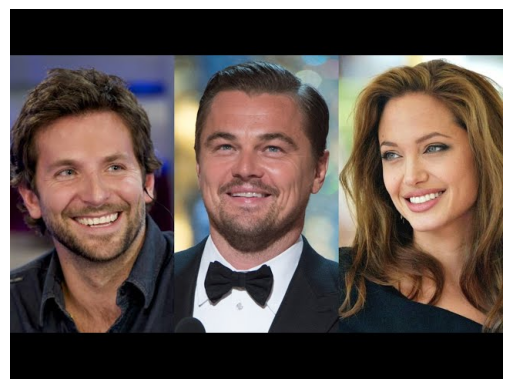

In [30]:
import urllib
from PIL import Image
img = Image.open(urllib.request.urlopen("https://i.ytimg.com/vi/ITP9_kH4MFI/sddefault.jpg"))
plt.axis('off')
plt.imshow(img)
plt.show()

In [31]:
mtcnn = MTCNN(keep_all=True)

In [32]:
x_test, prob = mtcnn(img, return_prob=True)
print(prob)
print(x_test.shape)

[0.99996006 0.99999917 0.999691  ]
torch.Size([3, 3, 160, 160])


In [33]:
test_aligned = x_test.to(device)
test_embeddings = net(test_aligned).detach().cpu()

In [34]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in test_embeddings]
test_no=[]
[test_no.append(i) for i in range(len(test_embeddings))]
print(pd.DataFrame(dists, columns=names, index=test_no))

   angelina_jolie  bradley_cooper  kate_siegel  paul_rudd  shea_whigham
0        1.463420        1.338802     1.334121   1.316544      1.298457
1        0.622794        1.393705     1.028543   1.345476      1.242009
2        1.351912        0.735692     1.338098   1.035901      1.077465


In [35]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in test_embeddings]
for dist in dists:
    if any(e<1 for e in dist):
        print(names[np.argmin(dist)])
    else:
        print('unknown')

unknown
angelina_jolie
bradley_cooper
